# **Problème du secrétaire**
#### ***Séminaire de Modélisation Statistique - 2A ENSAE***

## 1. Cadre du problème

Au cours du Séminaire de Modélisation Statistique (2A ENSAE), nous avons assisté à **une intervention de Vianney Perchet (CREST, Criteo) sur les algorithmes de matching**. Nous avons souhaité travailler sur **le problème du secrétaire** aussi appelé la « règle des $37\%$ » qui nous avait été présenté en interlude.

Le problème du secrétaire est le suivant : étant donné n nombres qui arrivent les uns après les autres et dans un ordre aléatoire, quelle est **la stratégie qui maximise la probabilité de sélectionner le plus élevé** ? Ce problème tient au fait que la décision d’accepter ou non un nombre doit être faite immédiatement et de manière irrévocable, sans connaître les nombres qui arrivent par la suite.

Une **stratégie naïve** serait de sélectionner le premier nombre : la probabilité que ça soit le plus élevé est de $1/n$ ! Cependant, **on peut maximiser cette probabilité** jusqu’à **la constante $1/e$, au moins** : il s’agit alors d’observer un échantillon composé des n/e premiers nombres (soit $37\%$ des nombres) puis de sélectionner ensuite le premier nombre supérieur au maximum de l’échantillon. Avec cette stratégie, si le maximum est dans l’échantillon, alors on sélectionne le dernier nombre et on a perdu. En revanche, si le maximum n’est pas dans l’échantillon mais que le deuxième plus grand y est, alors on a gagné.

On applique ce problème à celui du **recrutement online**. On peut le modéliser ainsi : $n$ candidats postulent les uns après les autres et dans un ordre aléatoire et on cherche à recruter le meilleur automatiquement. En effet, dès qu'un candidat postule, il passe un test qui reflète son niveau de compétences. Cependant, on ne connaît pas la répartition et les bornes des notes à ce test. On observe ensuite le résultat puis on choisit ou non de faire une offre. Si on ne fait pas l'offre au candidat en observant sa note, alors on ne peut plus lui faire d'offre par la suite.
L'objectif de notre projet sera ainsi de **définir la stratégie optimale qui permet de maximiser la probabilité de sélectionner le (ou les) meilleur(s) candidat(s) dans le recrutement online**.

Par ailleurs, dans la réalité, les entreprises composent aussi avec **des objectifs de diversité ou des contraintes budgétaires**. De fait, il y a un **coût d’opportunité** à ne pas avoir de diversité (l’entreprise perd en créativité, la marque employeur est affectée, etc.) ou à recruter un candidat avec des prétentions salariales trop fortes (inégalités salariales dans l’entreprise, moins de capacité de recrutement pour les prochains besoins). **Nous travaillerons donc enfin sur ces contraintes *business***, en particulier sur la diversité.

## 2. Etat de l'art

### 2.1. Démonstration du problème du secrétaire

L'objectif de cette section est de **montrer empiriquement la règle des $37\%$**.

Pour la démonstration mathématique, nous vous invitons à vous référer à l'article "La loi du $1/e$" (Carine Bartholmé, 2011).

Lien de l'article : https://bssm.ulb.ac.be/data/books/Bssm-2011-Carine-Bartholme.pdf

*On fixe d'abord la seed afin que nos résultats soient reproductibles.*

On créé ensuite **une fonction qui génère nos candidats aléatoirement**. Il s'agit d'une liste où **la position** de chaque élément correspond à son ordre d'arrivée et **le numéro correspondant** au classement du candidat au test (on considère qu'ils l'ont tous passé). Dans notre modèle, le recruteur ne voit pas le classement du candidat car il ne sait pas les notes des prochains candidats. Cependant, **l'ordinateur ne sachant pas que nos candidats sont classés, il fera des choix comme dans le vrai problème du secrétaire**.

In [1]:
import numpy as np
import random
#seed = 4

def generate_candidates(n):
    candidates = np.arange(1, n + 1)
    #random.Random(seed).shuffle(candidates)
    random.shuffle(candidates)
    return list(candidates)

**La stratégie optimale** :

1) **On rejette les $37\%$** (int(round(n/np.e))) **premiers candidats** : ils constituent **un échantillon**. 
2) On retient le premier candidat avec un meilleur niveau que le meilleur de notre échantillon (d'où l'index 0 dans chosen_candidate = better_candidates[0]). 
3) S'il n'y en a pas (parce que le meilleur candidat est dans notre échantillon), alors on retient le dernier candidat.

In [2]:
def choose_candidate(candidates: list, prop = 1 / np.e):
    sample_size = int(round(len(candidates) * prop))
    sample = candidates[:sample_size]
    best_from_sample = np.min(candidates[:sample_size])
    other_candidates = candidates[sample_size:]
    better_candidates = [candidate for candidate in other_candidates if candidate <= best_from_sample]
    if len(better_candidates) > 0:
        chosen_candidate = better_candidates[0]
    else:
        chosen_candidate = other_candidates[-1]
    return chosen_candidate

Exemple de simulation pour 100 candidats :

In [3]:
choose_candidate(generate_candidates(100), 1 / np.e)

1

On réalise $100 000$ simulations pour $100$ candidats et on trace les courbes de fréquence avec Matplotlib.
On constate que cette stratégie permet de sélectionner fréquemment le meilleur candidat : environ $37 000$ fois sur $100 000$ (soit **$37\%$ du temps**).

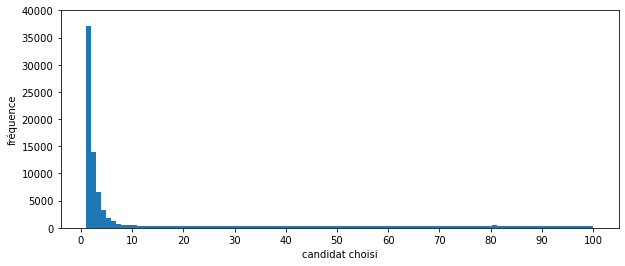

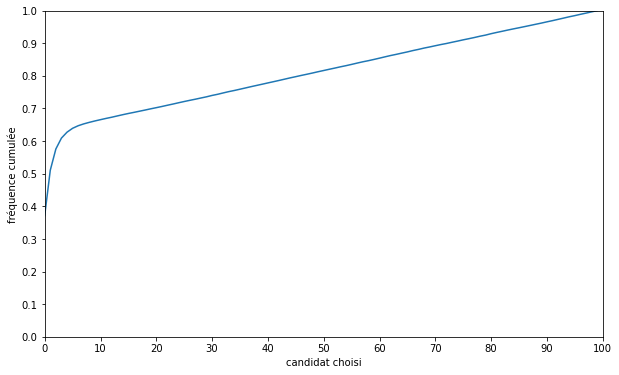

In [4]:
import matplotlib.pyplot as plt 

sim = np.array([choose_candidate(generate_candidates(n = 100)) for i in range(100000)])
plt.figure(figsize = (10, 4))
plt.hist(sim, bins = 100)
plt.xticks(np.arange(0, 101, 10))
plt.ylim(0, 40000)
plt.xlabel('candidat choisi')
plt.ylabel('fréquence')
plt.show()

# graphe pour obtenir la fréquence cumulée du choix du meilleur candidat

plt.figure(figsize = (10, 6))
plt.plot(np.cumsum(np.histogram(sim, bins = 100)[0]) / 100000)
plt.ylim(0,1)
plt.xlim(0, 100)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 101, 10))
plt.xlabel('candidat choisi')
plt.ylabel('fréquence cumulée')
plt.show()

On cherche à **déterminer empiriquement la proportion optimale de candidat à intégrer à l'échantillon**. Pour cela, on calcule les fréquences moyennes du choix du meilleur candidat en fonction de la proportion.

On trace également la courbe de $f(p) = -p*ln(p)$ qui est la probabilité de succès (cf. l'article), maximisée en $p = 1/e$.

processing: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


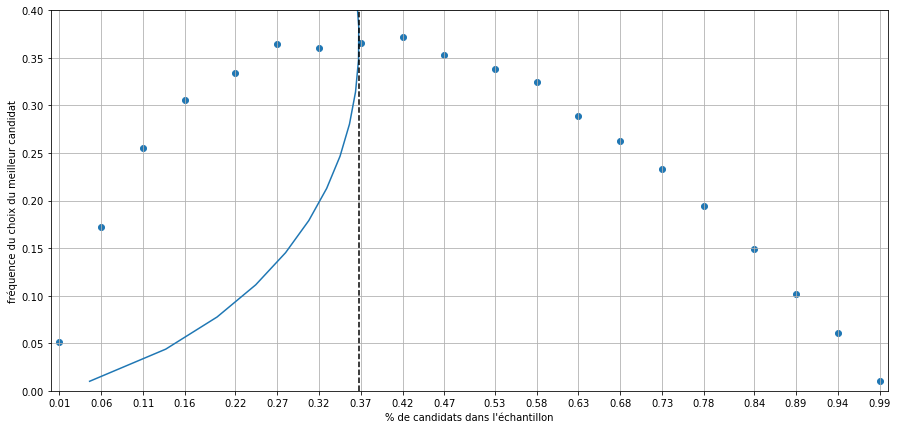

In [5]:
from tqdm import tqdm

props = [np.round(prop, 2) for prop in list(np.linspace(0.01, 0.99, num = 20))]
freq_best_candidate = []
for prop in tqdm(props, "processing"):
    sim = [choose_candidate(generate_candidates(100), prop) for i in range(10000)]
    freq_best_candidate.append(np.histogram(sim, bins = 100)[0][0] / 10000)

plt.figure(figsize=(15, 7))
plt.scatter(props, freq_best_candidate)
plt.xlim(0, 1)
plt.xticks(props)
plt.ylim(0, 0.4)
x = np.linspace(0.01,0.99,30)
f = -x*np.log(x)
plt.plot(f, x)
plt.xlabel("% de candidats dans l'échantillon")
plt.ylabel("fréquence du choix du meilleur candidat")
plt.grid(True)
plt.axvline(1 / np.e, ls = '--', c = 'black')
plt.show()

On constate que c'est bien avec une stratégie où on intègre $37\%$ des candidats dans l'échantillon (soit $1/e$) qu'on maximise la probabilité de tirer le meilleur candidat.

On peut cependant **modifier la stratégie** pour **retenir un des $k$ meilleurs candidats**. En effet, les entreprises sont souvent contraintes par le temps et sont prêtes à accepter un bon candidat, sans que ce dernier soit le meilleur.

processing for 10 best candidates: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


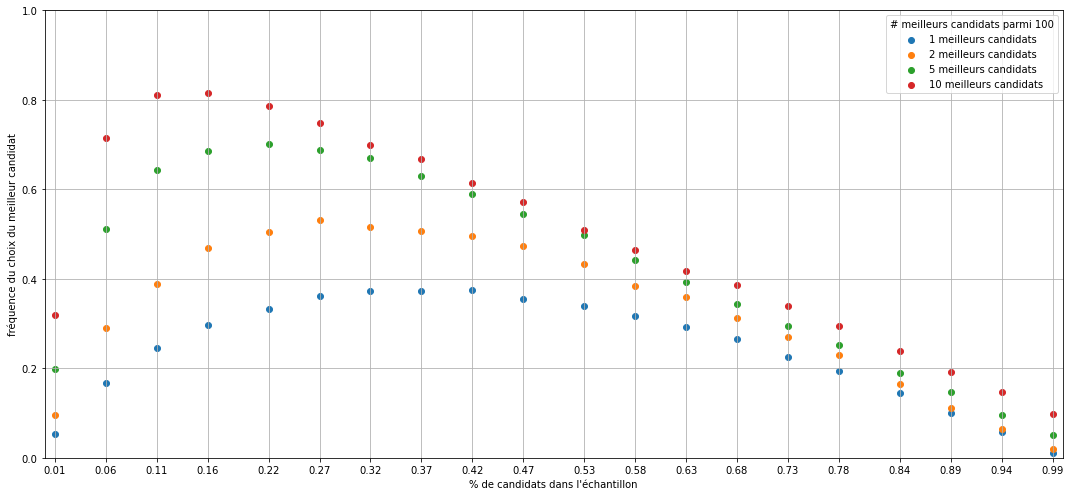

In [6]:
props = [np.round(prop, 2) for prop in list(np.linspace(0.01, 0.99, num = 20))]

plt.figure(figsize = (15, 7))
for k in [1, 2, 5, 10]:
    number_of_candidates = 100
    freq_best_candidate = []
    for prop in tqdm(props, f"processing for {k} best candidates"):
        sim = np.array([choose_candidate(generate_candidates(number_of_candidates), prop) for i in range(10000)])
        freq_best_candidate.append(len(sim[sim <= k]) / 10000)
    plt.scatter(props, freq_best_candidate, label = str(k) + f" meilleurs candidats")
plt.xlim(0, 1)
plt.xticks(props)
plt.ylim(0, 1)
plt.xlabel("% de candidats dans l'échantillon")
plt.ylabel("fréquence du choix du meilleur candidat")
plt.legend(title = f'# meilleurs candidats parmi {number_of_candidates}')
plt.grid(True)
plt.tight_layout()
plt.show()

On observe alors qu'en fonction du nombre de l'exigence du recrutement (on est prêt à accepter le k-ième meilleur candidat), **la stratégie évolue** : on ne compose plus un échantillon de $37\%$ des candidats mais de moins. 

Ainsi, on peut obtenir une probabilité de choisir un des dix meilleurs candidats parmi cent de de plus de $80\%$ en composant un échantillon de $15\%$ des candidats environ.

### 2.2. k-Secretary-Problem

On s'intéresse dans cette section au **k-Secretary Problem**. L'objectif n'est plus de sélectionner le meilleur candidat mais **$k$ candidats qui minimisent une fonction objectif convexe** (la somme des rangs des candidats, par exemple).

On distingue deux stratégies décrites dans l'article de Babaioff, Immorlica et al. (Cornell, 2007) : *virtual* et *optimistic*.
On compare les performances de ces deux stratégies.

Lien vers article : https://www.cs.cornell.edu/~rdk/papers/approx07.pdf

**Explication de la stratégie virtual pour $k = 2$ et $n$ candidats** :

Soit la fonction objectif convexe $F$ (somme des classements) et $n$ candidats.

1) On retient d'abord dans notre échantillon de taille $k$ $E = (z_{1} ... z_{k})$ le couple $(x^{\star},y^{\star})$ qui minimise $F(x,y)$, $\forall$ $(x,y) \in E$ et tel que $x^{\star} \leq y^{\star}$.

2) Ensuite, on parcourt les candidats restant $R = (z_{k+1} ... z_{n})$ pour remplir $res$ notre couple de candidats retenus : 
- pour chaque candidat $z_{i}$, on compare avec $y^{\star}$.
    - si $z_{i} \leq y^{\star}$ alors :
        - on retient $z_{1}^{\star} = z_{i}$ que l'on ajoute à $res$;
        - on pose le couple $( min(x^{\star},z_{1}^{\star}), max(x^{\star},z_{1}^{\star}) ) $ ;
        - on poursuit en comparant $z_{i+1}$ avec $max(x^{\star},z_{1}^{\star})$ pour trouver le deuxième candidat 
- sinon, on passe à $z_{i+1}$ et on itère 


3) On s'arrête une fois qu'on a trouvé les deux candidats retenus. Si on arrive au dernier candidat, alors on retient $res = (z_{1}^{\star},z_{n})$ ou $res = (z_{n-1},z_{n})$ si on n'a pas trouvé de $z_{i} \leq y^{\star}$.

Dans notre cas, nous choisissons **la somme des rangs des candidats retenus** comme fonction objectif à minimiser : elle reflète bien notre objectif de sélectionner les meilleurs candidats.

In [7]:
# Virtual strategy

def virtual_choose_k_candidates(candidates, prop, k):
    
    # on définit notre échantillon et on retient les k meilleurs de notre échantillon
    # ces k meilleurs minimisent notre fonction objectif (somme des rangs)
    sample_size = int(round(len(candidates) * prop))
    sample = candidates[:sample_size]
    best_from_sample = sorted(sample)[:k]
    #print("best_from_sample :")
    #display(best_from_sample)
    
    other_candidates = candidates[sample_size:]
    chosen_candidates = []
    remaining_candidates = len(other_candidates)
    #print(f"remaining_candidates : {remaining_candidates}")

    for x in other_candidates:
        # si on a encore des candidats à choisir
        if len(chosen_candidates) < k:
            # s'il reste suffisamment de candidats à voir
            if remaining_candidates > k - len(chosen_candidates):
                # si le candidat observé est meilleur que le moins bons des candidats retenus dans l'échantillon
                if x < best_from_sample[-1]:
                    # alors on le choisit
                    chosen_candidates.append(x)
                    #print("chosen_candidates :")
                    #display(chosen_candidates)
                    # on remplace le moins bons des candidats retenus dans l'échantillon par ce candidat
                    best_from_sample[-1] = x
                    # on refait un tri
                    # cela permet de comparer le candidat suivant avec le moins bon des meilleurs candidats observés
                    best_from_sample = sorted(best_from_sample)
                    #print("best_from_sample :")
                    #display(best_from_sample)
            else:
                chosen_candidates.append(x)
            remaining_candidates -= 1
            #print(remaining_candidates)
        else:
            return chosen_candidates
    
    return chosen_candidates

number_of_candidates = 1000
k = 10
sample_size = 0.37
candidates = generate_candidates(number_of_candidates)
max_score = sum(sorted(generate_candidates(number_of_candidates))[:k])
display(f"max_score is {max_score} for {k} best candidates amongst {number_of_candidates}")
chosen_candidates = virtual_choose_k_candidates(candidates, sample_size, k)
print(f"virtual_algo_score is {sum(chosen_candidates)} for {k} best candidates amongst {number_of_candidates}")
print("chosen_candidates :")
display(chosen_candidates)

'max_score is 55 for 10 best candidates amongst 1000'

virtual_algo_score is 686 for 10 best candidates amongst 1000
chosen_candidates :


[3, 8, 10, 1, 11, 13, 9, 4, 429, 198]

On observe **la fréquence des scores** obtenus avec la stratégie virtual sachant que, dans notre cas (les candidats sont classés), le score minimal est :

$$\frac{n(n+1)}{2}$$

avec $n$ le nombre de candidats.

In [1]:
number_of_candidates = 100
k = 10
sample_size = 0.37
print(f"on se place dans le cas où on sélectionne {k} candidats parmi {number_of_candidates} avec une taille d'échantillon de {sample_size}")
n_sim = 10000
print(f"on effectue {n_sim} simulations")
sim = np.array([sum(virtual_choose_k_candidates(generate_candidates(number_of_candidates), sample_size, k)) for i in range(n_sim)])
plt.figure(figsize = (15, 4))
plt.hist(sim, bins = 10)
plt.xticks(np.arange(55, 400, 20))
plt.ylim(0, 5000)
plt.xlim(55, 500)
plt.xlabel('répartition des score de la stratégie virtual')
plt.ylabel(f'fréquence pour {n_sim} simulations')
plt.show()

on se place dans le cas où on sélectionne 10 candidats parmi 100 avec une taille d'échantillon de 0.37
on effectue 10000 simulations


NameError: name 'np' is not defined

On cherche la **taille optimale de l'échantillon** avec la stratégie virtual. On calcule donc le score moyen de notre choix (la somme des rangs des candidats) en fonction de la proportion de candidats dans l'échantillon.

processing through props: 100%|██████████| 20/20 [02:28<00:00,  7.42s/it]


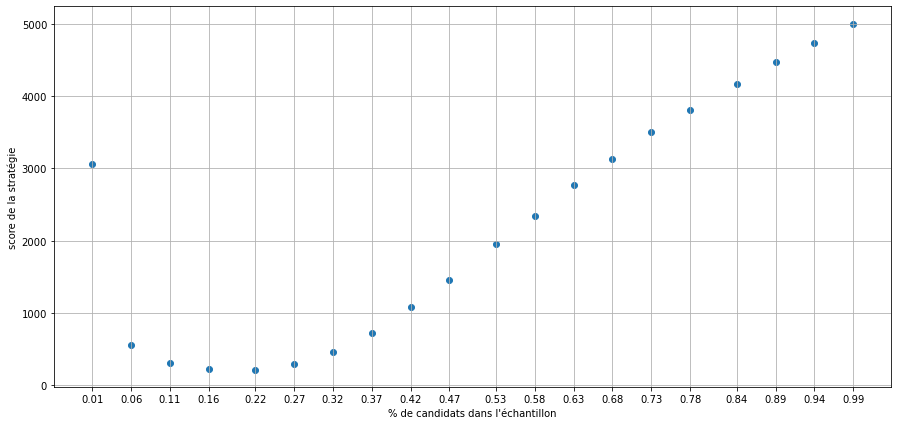

In [9]:
from tqdm import tqdm
number_of_candidates = 1000
k = 10

props = [np.round(prop, 2) for prop in list(np.linspace(k / number_of_candidates, 1 - k / number_of_candidates, num = 20))]
score_virtual = []
for prop in tqdm(props, "processing through props"):
    sim_virtual = np.array([sum(virtual_choose_k_candidates(generate_candidates(number_of_candidates), prop, k)) for i in range(10000)])
    score_virtual.append(np.mean(sim_virtual))

plt.figure(figsize = (15, 7))
plt.scatter(props, score_virtual)
plt.xticks(props)
plt.xlabel("% de candidats dans l'échantillon")
plt.ylabel("score de la stratégie")
plt.grid(True)
plt.show()

Passons désormais à **la stratégie *optimistic***, toujours avec la même fonction objectif.

**Explication de la stratégie optimistic pour $k = 2$ et $n$ candidats** :

Soit la fonction objectif convexe $F$ (somme des classements) et $n$ candidats

1) Comme dans la stratégie vitual, on retient d'abord dans notre échantillon de taille $k$ $E = (z_{1} ... z_{k})$ le couple $(x^{\star},y^{\star})$ qui minimise $F(x,y)$, $\forall$ $(x,y) \in E$ et tel que $x^{\star} \leq y^{\star}$.

2) Ensuite, on parcourt les candidats restant $R = (z_{k+1} ... z_{n})$ pour remplir $res$ notre couple de candidats retenus : 
- pour chaque candidat $z_{i}$, on compare avec $y^{\star}$.
- si $z_{i} \leq y^{\star}$ alors :
    - on retient $z_{1}^{\star} = z_{i}$ que l'on ajoute à $res$;
    - on supprime ensuite $y^{\star}$;
    - on poursuit en comparant $z_{i+1}$ avec $x^{\star}$
    
- sinon, on passe à $z_{i+1}$ et on itère

3) On s'arrète lorsque $res$ contient deux valeurs, si on arrive au dernier candidat, alors on retient $res = (z_{1}^{\star},z_{n})$ ou $res = (z_{n-1},z_{n})$ si on n'a pas trouvé de $z_{i} \leq y^{\star}$.

In [10]:
# Optimistic strategy

def optimistic_choose_k_candidates(candidates, prop, k):

    sample_size = int(round(len(candidates) * prop))
    sample = candidates[:sample_size]
    best_from_sample = sorted(sample)[:k]

    other_candidates = candidates[sample_size:]
    chosen_candidates = []
    remaining_candidates = len(other_candidates)

    for x in other_candidates:
        if len(chosen_candidates) < k:
            if remaining_candidates > k - len(chosen_candidates):
                if x < best_from_sample[-1]:
                    chosen_candidates.append(x)
                    del best_from_sample[-1]
            else:
                chosen_candidates.append(x)
            remaining_candidates -= 1
        else:
            return chosen_candidates
    
    return chosen_candidates

number_of_candidates = 1000
k = 10
sample_size = 0.37
candidates = generate_candidates(number_of_candidates)
max_score = sum(sorted(generate_candidates(number_of_candidates))[:k])
display(f"max_score is {max_score} for {k} best candidates amongst {number_of_candidates}")
chosen_candidates = optimistic_choose_k_candidates(candidates, sample_size, k)
print(f"optimistic_algo_score is {sum(chosen_candidates)} for {k} best candidates amongst {number_of_candidates}")
print("chosen_candidates :")
display(chosen_candidates)

'max_score is 55 for 10 best candidates amongst 1000'

optimistic_algo_score is 793 for 10 best candidates amongst 1000
chosen_candidates :


[7, 21, 10, 5, 2, 1, 3, 9, 6, 729]

On compare les performances des deux algorithmes virtual et optimistic en faisant varier le score moyen (obtenu à partir de $10 000$ simulations).

on se place dans le cas où on sélectionne 10 candidats parmi 100
on effectue 10000 simulations


processing through props: 100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


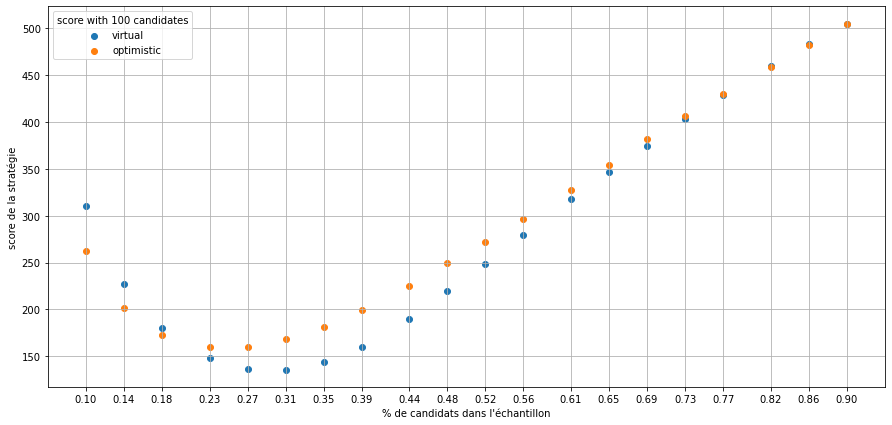

In [11]:
from tqdm import tqdm
number_of_candidates = 100
k = 10
n_sim = 10000

print(f"on se place dans le cas où on sélectionne {k} candidats parmi {number_of_candidates}")
print(f"on effectue {n_sim} simulations")

props = [np.round(prop, 2) for prop in list(np.linspace(k / number_of_candidates, 1 - k / number_of_candidates, num = 20))]
score_virtual = []
score_optimistic = []
for prop in tqdm(props, "processing through props"):
    sim_virtual = np.array([sum(virtual_choose_k_candidates(generate_candidates(number_of_candidates), prop, k)) for i in range(n_sim)])
    score_virtual.append(np.mean(sim_virtual))
    sim_optimistic = np.array([sum(optimistic_choose_k_candidates(generate_candidates(number_of_candidates), prop, k)) for i in range(n_sim)])
    score_optimistic.append(np.mean(sim_optimistic))

plt.figure(figsize = (15, 7))
plt.scatter(props, score_virtual, label = "virtual")
plt.scatter(props, score_optimistic, label = "optimistic")
plt.xticks(props)
plt.xlabel("% de candidats dans l'échantillon")
plt.ylabel("score de la stratégie")
plt.legend(title = f'score with {number_of_candidates} candidates')
plt.grid(True)
plt.show()

## 3. Problème du secrétaire sous contraintes

On s'intéresse désormais au **problème du secrétaire avec contraintes**. On ajoute au problème du secrétaire une contrainte (ou plus exactement un bonus) de parité. 

Dans le cas  $k = 2$ que nous traitons ici, cela signifie que l'entreprise reçoie un bonus si les candidats sélectionnées sont un homme et une femme. Ainsi la fonction à minimiser n'est plus uniquement la somme de la valeur des deux candidats mais prend en compte également leur sexe. 

Nous regardons tout d'abord les résultats de parité que l'on obtient lorsque applique la stratégie virtual explicitée auparavant : a priori, nous devrions obtenir la même proportion de femme dans les candidats retenus qu'il n'y avait de femmes dans l'échantillon de départ.

Ensuite, nous cherchons à **adapter la stratégie virtual pour prendre en compte le bonus de parité**. 


**Notre modèle** :

Pour aboder la question de la diversité dans le recrutement, il faut faire en sorte que l'entreprise ne puisse pas **traiter deux problèmes indépendants**.

Par exemple, si on cherche à recruter $x$ femmes parmi $k$ recrutements, on recrute séparément les $k-x$ hommes et les $x$ femmes.

En revanche, les problèmes "au moins $x$ femmes parmi $k$ recrutements" ou de bonus parité (ou de pénalité) permettent d'avoir **une dépendance dans la sélection** : si je recrute un homme alors je *dois* recruter plus de femmes par la suite, ou inversement si je recrute une femme alors je *peux* recruter plus d'hommes par la suite, et *vice versa*.

Nous avons fait le choix d'**introduire un bonus parité** et d'**observer son effet sur le sexe des candidats retenus**. En particulier, nous faisons varier la proportion de femmes dans les candidats et nous souhaitons avoir davantage de parité (dans les candidats retenus).

**1) Fonction qui génère des candidats avec gender** :

Tout d'abord, nous codons une fonction qui génère nos candidats en tenant compte du genre. Pour cela, nous créons un DataFrame.

In [12]:
import pandas as pd

def generate_candidates_gender(n, prop = 0.4):
    candidates = np.arange(1, n + 1)
    np.random.shuffle(candidates)
    candidates = list(candidates)
    gender = list(np.random.binomial(1, prop, n))
    #candidates = [[candidate, gender] for candidate, gender in zip(candidates, gender)]
    candidates = pd.DataFrame((zip(candidates, gender)), columns = ['candidate', 'gender'])
    return candidates

La répartition des femmes dans les candidats suit donc une loi binomiale de paramètre (prop,n). Cettre distribution est censée représenter le fait que les femmes soient largement sous représentée dans certaines catégories professionelles (parmi les ingénieurs par exemple), ainsi moins de femmes se présentent aux entretiens. 

**2) Stratégie virtual sans bonus parité** :

In [13]:
prop_women = 0.3
k = 20
prop = 0.37
candidates = generate_candidates_gender(100, prop_women)
prop_women_amongst_best = sum(candidates.sort_values(by = "candidate")["gender"][:k]) / k
best_possible_score = sum(candidates.sort_values(by = "candidate")["candidate"][:k])
chosen_candidates = virtual_choose_k_candidates(candidates['candidate'].values, prop, k)
score = sum(chosen_candidates)
print(f"score = {score} vs. best possible score = {best_possible_score} ") 

def parity_score(candidates, chosen_candidates):
    chosen_genders = []
    for i in range(len(candidates)):
        if candidates['candidate'][i] in chosen_candidates:
            chosen_genders.append(candidates['gender'][i])
    parity_score = np.sum(chosen_genders) / len(chosen_genders)
    return float(parity_score)

parity_score_sim = parity_score(candidates, chosen_candidates)
print(f"parity_score is {parity_score_sim} when prop of women is {prop_women} and when prop of women amongst top {k} is {prop_women_amongst_best}")

score = 436 vs. best possible score = 210 
parity_score is 0.25 when prop of women is 0.3 and when prop of women amongst top 20 is 0.35


Dans le cas sans bonus parité, on remarque que le score de parité est proche de la proportion de femme qu'on a choisit. On teste ensuite cette méthode pour différents pourcentage de femme parmi les candidats initiaux. 

100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


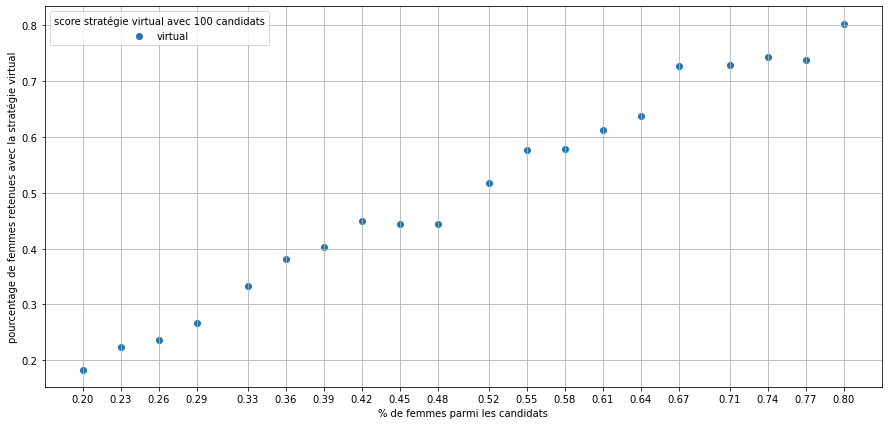

In [14]:
from tqdm import tqdm
k = 2
prop = 0.37
props_women = [np.round(prop, 2) for prop in list(np.linspace(0.2, 0.8, num = 20))]

parity_score_virtual = []
for prop_women in tqdm(props_women):
    sim_parity_virtual = []
    for i in range(300):
        candidates = generate_candidates_gender(100, prop_women)
        chosen_candidates = virtual_choose_k_candidates(candidates['candidate'].values, prop, k)
        sim_parity_virtual.append(parity_score(candidates, chosen_candidates))
    mean_parity_score_virtual = sum(sim_parity_virtual) / len(sim_parity_virtual)
    parity_score_virtual.append(mean_parity_score_virtual)
    
plt.figure(figsize = (15, 7))
plt.scatter(props_women, parity_score_virtual, label = "virtual")
plt.xticks(props_women)
plt.xlabel("% de femmes parmi les candidats")
plt.ylabel("pourcentage de femmes retenues avec la stratégie virtual")
plt.legend(title = f'score stratégie virtual avec {number_of_candidates} candidats')
plt.grid(True)
plt.show()

On observe une relation linéaire : la parité n'est pas incitée et dépends donc uniquement de la distribution intiale des candidats. Ainsi le processus de recrutement reproduit la non-parité des candidats. 

**3) Stratégie avec bonus parité** :

**Explication de la stratégie virtual adaptée avec bonus pour $k = 2$ et $n$ candidats** :

Soit la fonction objectif convexe $F$ (somme des rangs +bonus $*\mathbb{1}(parité)$ ) et $n$ candidats

1) On retient d'abord dans notre échantillon de taille $k$  $E = (z_{1} ... z_{k})$ le couple $(x^{\star},y^{\star})$ qui minimise $F(x,y)$, $\forall$ $(x,y) \in E$ et tel que $x^{\star} \leq y^{\star}$.

2) On choisit le premier candidat en tenant compte uniquement de son rang, donc en appliquant la stratégie virtual classique. On note $k0$ son rang. Si $k0$=n ,$res=(z_{i},y^{\star})$. 

3) En revanche, si $i0$ < n, on parcourt les candidats restant $R = (z_{i0} ... z_{n})$ pour trouver le deuxième candidat retenu dans $res$: 
- pour chaque candidat $z_{i}$, on cherche  $ min( F(x^{\star},y^{\star}) ,  F(z_{i},y^{\star}) , F(x^{\star},z_{i}) )$. 
- si $F(z_{i},y^{\star})$ est le mininum alors :
    - on retient $z_{1}^{\star} = z_{i}$ que l'on ajoute à $res$;
    - on pose le couple $( min(z_{1}^{\star},y^{\star}), max(z_{1}^{\star},y^{\star}) ) $ ;
    - on passe à $z_{i+1}$
- si $F(x^{\star},z_{i})$ est le mininum alors :
    - on retient $z_{1}^{\star} = z_{i}$ que l'on ajoute à $res$;
    - on pose le couple $( min(x^{\star},z_{1}^{\star}), max(x^{\star},z_{1}^{\star}) ) $ ;
    - on passe à $z_{i+1}$
- sinon, on passe à directement $z_{k0+1}$


On définit notre fonction objectif comme la somme des rangs des candidats avec un bonus en cas de parité.

In [15]:
def objective_function(selected_candidates, bonus):
    candidate = selected_candidates['candidate']
    if sum(selected_candidates['gender']) == len(selected_candidates) / 2:
        return sum(candidate) - bonus
    else:
        return sum(candidate)

On cherche les meilleurs candidats de notre échantillon i.e. les candidats qui minimisent la fonction objectif.
Pour ce faire, on définit au préalable deux fonctions :
- find_best_from_samplev1 qui parcourt toutes les combinaisons possibles de variables
- find_best_from_samplev2 qui dans le cas $k = 2$ ne se penche que sur quelques résultats.

Dans le cas $k = 2$, la fonction find_best_from_samplev2 permet de faire aussi rapidement les calculs pour 1000 candidats que pour 100 (contrairement à find_best_from_samplev1).

In [16]:
from itertools import combinations

def find_best_from_samplev1(sample, k, bonus):
    possibilities = list(combinations(list(sample.index), k))
    #print(f"number of possibilities for best_from_sample = {len(possibilities)}")
    best_from_sample = sample.iloc[list(possibilities[0])]
    best_score = objective_function(best_from_sample, bonus)
    for possibility in tqdm(possibilities, "processing through combinations", disable = True):
        if objective_function(sample.iloc[list(possibility)], bonus) < objective_function(best_from_sample, bonus):
            best_from_sample = sample.iloc[list(possibility)]
            best_score_sample = objective_function(best_from_sample, bonus)
    #print(f"best_score_sample is {best_score_sample}")
    return best_from_sample.sort_values(by = "candidate").reset_index(drop = True)

def find_best_from_samplev2(sample, k, bonus):
    
    if len(sample) < 2:
        return "veuillez saisir un nombre de candidat ou une taille d'échantillon plus grands"
    
    if k == 2:
        sorted_sample = sample.sort_values(by = 'candidate').reset_index(drop = True)
        if sorted_sample["gender"][0] != sorted_sample["gender"][1]:
            return sorted_sample.iloc[[0,1]]
        else:
            nb_women = sorted_sample["gender"].sum()
            nb_men = len(sample) - nb_women
            if (nb_women == 0) or (nb_men == 0):
                return sorted_sample.iloc[[0,1]]
            else:
                women_sample = sorted_sample[sorted_sample["gender"] == 1].reset_index(drop = True)
                men_sample = sorted_sample[sorted_sample["gender"] == 0].reset_index(drop = True)
                mix_score = women_sample.iloc[0]["candidate"] + men_sample.iloc[0]["candidate"] - bonus
                if nb_women >= 2:
                    women_score = women_sample.iloc[0]["candidate"] + women_sample.iloc[1]["candidate"]
                    if nb_men >= 2:
                        men_score = men_sample.iloc[0]["candidate"] + men_sample.iloc[1]["candidate"]
                        min_score = min(mix_score, women_score, men_score)
                        if min_score == mix_score:
                            best_woman_df = pd.DataFrame(women_sample.iloc[0]).transpose()
                            best_man_df = pd.DataFrame(men_sample.iloc[0]).transpose()
                            return pd.concat([best_woman_df,best_man_df])
                        elif min_score == women_score:
                            return women_sample.iloc[[0,1]]
                        else:
                            return men_sample.iloc[[0,1]]
                    else:
                        min_score = min(mix_score, women_score)
                        if min_score == mix_score:
                            best_woman_df = pd.DataFrame(women_sample.iloc[0]).transpose()
                            best_man_df = pd.DataFrame(men_sample.iloc[0]).transpose()
                            return pd.concat([best_woman_df,best_man_df])
                        else:
                            return women_sample.iloc[[0,1]]
                else:
                    men_score = men_sample.iloc[0]["candidate"] + men_sample.iloc[1]["candidate"]
                    min_score = min(mix_score, men_score)
                    if min_score == mix_score:
                        best_woman_df = pd.DataFrame(women_sample.iloc[0]).transpose()
                        best_man_df = pd.DataFrame(men_sample.iloc[0]).transpose()
                        return pd.concat([best_woman_df,best_man_df])
                    else:
                        return men_sample.iloc[[0,1]]
    else:
        possibilities = list(combinations(list(sample.index), k))
        #print(f"number of possibilities for best_from_sample = {len(possibilities)}")
        best_from_sample = sample.iloc[list(possibilities[0])]
        best_score = objective_function(best_from_sample, bonus)
        for possibility in tqdm(possibilities, "processing through combinations", disable = True):
            if objective_function(sample.iloc[list(possibility)], bonus) < objective_function(best_from_sample, bonus):
                best_from_sample = sample.iloc[list(possibility)]
                best_score_sample = objective_function(best_from_sample, bonus)
        #print(f"best_score_sample is {best_score_sample}")
        return best_from_sample.sort_values(by = "candidate").reset_index(drop = True)

On code notre stratégie virtual tenant compte du genre.
Comme expliqué auparavant, notre stratégie sélectionne le premier candidat en tenant compte uniquement de son rang et pas de son genre.

In [17]:
def virtual_choose_k_candidates_gender(candidates, prop, k, bonus):
    
    if k <= 1:
        return "please select a greater number of candidates to choose for the k-secretary problem"
    
    # best_from_sample
    sample_size = int(round(len(candidates) * prop))
    sample = candidates.iloc[list(range(sample_size))]
    best_from_sample = find_best_from_samplev2(sample, k, bonus) # DataFrame
    #print("best_from_sample :")
    #display(best_from_sample)
    
    # select best candidates
    other_candidates = candidates.iloc[list(range(sample_size, len(candidates)))].reset_index(drop = True)
    #print("10 premiers candidats hors échantillon")
    #display(other_candidates[:10])
    chosen_candidates = pd.DataFrame(columns = ["candidate", "gender"])
    remaining_candidates = len(other_candidates)
    
    for index in tqdm(range(len(other_candidates)), disable = True):
        
        # choix du premier candidat : on sélectionne le meilleur
        if len(chosen_candidates) < 1:
            # s'il reste encore suffisamment de candidats à observer : on continue à chercher le meilleur
            if remaining_candidates > k - len(chosen_candidates):
                # si le candidat est meilleur que le pire des candidats sélectionnés dans l'échantillon
                # alors on le sélectionne, sinon on continue à chercher
                remaining_candidates -= 1
                if other_candidates["candidate"][index] < list(best_from_sample["candidate"])[-1]:
                    chosen_candidates = pd.concat([chosen_candidates,pd.DataFrame(other_candidates.iloc[index]).transpose()], ignore_index = True)
                    #print("first chosen candidate")
                    #display(chosen_candidates)
                    # stratégie virtual
                    best_from_sample.loc[len(best_from_sample) - 1] = chosen_candidates.loc[len(chosen_candidates) - 1]
                    best_from_sample = best_from_sample.sort_values(by = "candidate").reset_index(drop = True)
                    #print("modified best_from_sample")
                    #display(best_from_sample)
            # s'il n'y a plus assez de candidats à observer : on sélectionne tous les derniers
            else:
                #print("remaining_candidates :")
                #print(remaining_candidates)
                #print("a")
                return pd.concat([chosen_candidates, other_candidates.iloc[range(len(other_candidates) - k, len(other_candidates))]], ignore_index=True)
        
        # le premier candidat a été choisi : on sélectionne les suivants
        else:
            # on vérifie s'il reste assez de candidats à sélectionner
            if remaining_candidates > k - len(chosen_candidates):
                # si on a déjà atteint le nombre de candidats à retenir, on retourne ces derniers
                if len(chosen_candidates) == k:
                    #print("remaining_candidates :")
                    #print(remaining_candidates)
                    #print("b")
                    return chosen_candidates
                # sinon, on choisit un nouveau candidat
                else:
                    remaining_candidates -= 1
                    # on applique la stratégie virtual avec la fonction objectif
                    saved_index = -1
                    # on parcourt les meilleurs de l'échantillon (best_from_sample)
                    for index_sample in range(len(best_from_sample)):
                        aux = best_from_sample.copy()
                        aux.loc[index_sample] = other_candidates.loc[index]
                        if objective_function(aux, bonus) < objective_function(best_from_sample, bonus):
                            saved_index = index_sample
                    if saved_index >= 0:
                        chosen_candidates = pd.concat([chosen_candidates,pd.DataFrame(other_candidates.iloc[index]).transpose()], ignore_index = True)
                        best_from_sample.loc[saved_index] = other_candidates.loc[index]
                        best_from_sample = best_from_sample.sort_values(by = "candidate").reset_index(drop = True)
                        #print("modified best_from_sample")
                        #display(best_from_sample)

            else:
                #print("remaining_candidates :")
                #print(remaining_candidates)
                #print("c")
                return pd.concat([chosen_candidates, other_candidates.iloc[range(len(other_candidates) - len(chosen_candidates), len(other_candidates))]], ignore_index=True)
    #print("remaining_candidates :")
    #print(remaining_candidates)
    #print("d")    
    return chosen_candidates

Voici un exemple de simulation où on cherche à recruter $2$ candidats avec $100$ candidats au départ dont $40\%$ de femmes et avec un bonus de $20$ si parité.

In [18]:
candidates = generate_candidates_gender(100, prop_women)
prop = 0.4
k = 2
bonus = 20
virtual_choose_k_candidates_gender(candidates, prop, k, bonus)

,candidate,gender
0,1,1
1,9,1


processing through props_women: 100%|██████████| 10/10 [03:26<00:00, 20.67s/it]


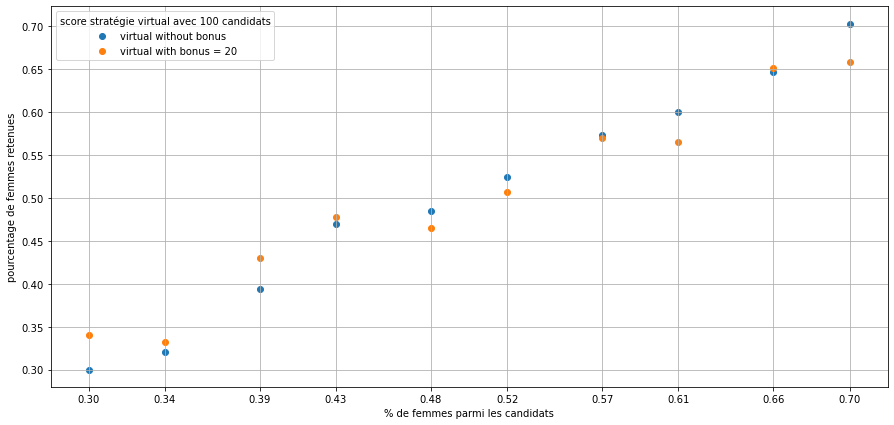

In [19]:
k = 2
prop = 0.37
bonus = 20
props_women = [np.round(prop, 2) for prop in list(np.linspace(0.3, 0.7, num = 10))]

parity_score_virtual = []
parity_score_virtual_bonus = []
for prop_women in tqdm(props_women, "processing through props_women"):
    sim_parity_virtual = []
    sim_parity_virtual_bonus = []
    for i in range(300):
        candidates = generate_candidates_gender(1000, prop_women)
        chosen_candidates = virtual_choose_k_candidates(candidates['candidate'].values, prop, k)
        sim_parity_virtual.append(parity_score(candidates, chosen_candidates))
        chosen_candidates_bonus = virtual_choose_k_candidates_gender(candidates, prop, k, bonus)
        sim_parity_virtual_bonus.append(np.mean(chosen_candidates_bonus['gender'].values))
    mean_parity_score_virtual = sum(sim_parity_virtual) / len(sim_parity_virtual)
    parity_score_virtual.append(mean_parity_score_virtual)
    mean_parity_score_virtual_bonus = sum(sim_parity_virtual_bonus) / len(sim_parity_virtual_bonus)
    parity_score_virtual_bonus.append(mean_parity_score_virtual_bonus)
    
plt.figure(figsize = (15, 7))
plt.scatter(props_women, parity_score_virtual, label = "virtual without bonus")
plt.scatter(props_women, parity_score_virtual_bonus, label = f"virtual with bonus = {bonus}")
plt.xticks(props_women)
plt.xlabel("% de femmes parmi les candidats")
plt.ylabel("pourcentage de femmes retenues")
plt.legend(title = f'score stratégie virtual avec {number_of_candidates} candidats')
plt.grid(True)
plt.show()

**On observe une meilleure parité avec la stratégie avec bonus !**

On fait désormais varier le bonus à proportion de femmes constante (à $17\%$ soit la part des femmes dans la tech en 2020 selon l'étude Gender Scan 2022). On observe la variation de la proportion de femmes choisies.

Lien de l'étude : https://www.genderscan.org/Docs/Gender_Scan_Synthese_2022_France.pdf

processing through bonuses: 100%|██████████| 15/15 [05:14<00:00, 20.96s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


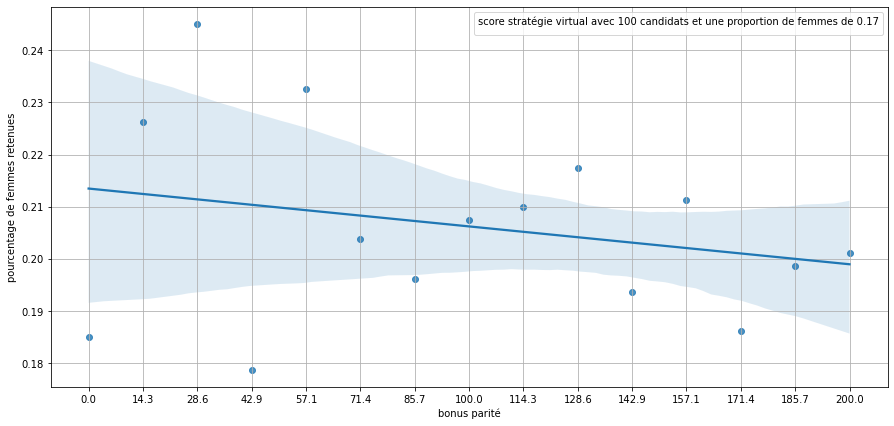

In [20]:
import seaborn as sns

k = 2
prop = 0.37
prop_women = 0.17
bonuses = [np.round(bonus, 2) for bonus in list(np.linspace(0, 200, num = 15))]

parity_score_virtual_bonus = []
for bonus in tqdm(bonuses, "processing through bonuses"):
    sim_parity_virtual_bonus = []
    for i in range(400):
        candidates = generate_candidates_gender(1000, prop_women)
        chosen_candidates_bonus = virtual_choose_k_candidates_gender(candidates, prop, k, bonus)
        sim_parity_virtual_bonus.append(np.mean(chosen_candidates_bonus['gender'].values))
    mean_parity_score_virtual = sum(sim_parity_virtual) / len(sim_parity_virtual)
    parity_score_virtual.append(mean_parity_score_virtual)
    mean_parity_score_virtual_bonus = sum(sim_parity_virtual_bonus) / len(sim_parity_virtual_bonus)
    parity_score_virtual_bonus.append(mean_parity_score_virtual_bonus)
    
plt.figure(figsize = (15, 7))
plt.xticks(bonuses)
sns.regplot(x=bonuses, y=parity_score_virtual_bonus, fit_reg=True)
plt.xlabel("bonus parité")
plt.ylabel("pourcentage de femmes retenues")
plt.legend(title = f'score stratégie virtual avec {number_of_candidates} candidats et une proportion de femmes de {prop_women}')
plt.grid(True)

plt.show()

On constate encore que mettre **un bonus parité augmente la proportion de femmes dans les candidats retenus**. Cependant, **augmenter le bonus n'augmente pas cette proportion** qui stagne autour de $25\%$.

## 4. Conclusions

### 4.1. Conclusion générale :

En conclusion, ce projet nous a permis de modéliser des **extensions du problème du secrétaire** présenté en cours. Tout d'abord nous avons montré qu'en essayant de choisir non pas le meilleur mais l'un des i meilleurs candidats, il était possible de réduire le nombre de candidats du premier groupe (ceux dont on regarde les résultats sans les prendre). Ensuite, nous nous sommes intéressés au cas où on recrutait plusieurs candidats pour voir comment les stratégies de recrutement étaient modifiées. Ces résultats préliminaires nous ont permis, par la suite d'ajouter une contrainte au problème initial. La nouvelle stratégie que nous avons mis en place dans une situation avec un bonus parité semble **performante** puisqu'elle permet d'obtenir un **meilleur score de parité**. 

Nous avons particulièrement apprécié travailler sur ce projet car il nous a permis d'appliquer des outils de modélisation statistique à des sujets actuels de société. Même si nous avons choisi de nous concentrer sur la parité, les mêmes méthodes pourraient permettre de s'intéresser plus généralement à d'autres **enjeux de diversité** dans le recrutement ou bien d'inclure des **contraintes business** auxquelles font face les sociétés. 



### 4.2. Difficultés rencontrées :

La première difficultée que nous avons rencontré en abordant ce projet concernait la **généralisation du le problème du secrétaire pour k candidats choisis**. La résolution théorique du problème devient tout de suite bien  plus compliquée lorsqu'on cherche à recruter plus d'un candidat. De plus, il n'y a pas encore beaucoup de littérature sur ce problème qui est relativement récent puisqu'il a été introduit en 2005 par  Kleinberg. 

Un autre enjeu était de réussir à **modéliser la question de la parité dans le processus de recrutement**. Nous voulions créer un modèle reflétant le plus possible la réalité mais il fallait aussi que la situation puisse être implémenté facilement. Nous avons donc du faire un certain nombre d'hypothèses simplificatrices sur les données de départ du problème et la stratégie de recrutement. 


### 4.3. Pistes d'amélioration :

Il y plusieurs pistes d'amélioration qui pourraient être exploitées pour poursuivre ce projet.

   Tout d'abord en ce qui concerne la **distribution des hommes et des femmes** dans l'échantillon des candidats, nous pourrions tester différentes manières d'obtenir le nombre de femmes et les classements des candidats. On aurait pu tirer les classements des hommes en utilisant une loi uniforme discrète sur $\left[ 1;50 \right]$ et ceux des femmes avec une loi uniforme discrète sur$ \left[ 5;40 \right]$.
    
   Nous avons choisi la stratégie avec bonus en fonction de ce qui nous parraissait le plus logique mais nous n'avons pas de preuve théorique qu'elle est là plus performante. On pourrait tester différentes méthodes comme par exemple **choisir le premier candidat en fonction du sexe minoritaire** dans l'échantillon de départ et comparer les résultats avec ceux obtenus avec la première méthode.  
    
   Enfin en faisant **varier la fonction objectif convexe**, on pourrait trouver différentes manières de valoriser la diversité. On aurait aussi pu faire varier le bonus parité attribué pour voir son effet sur les résultats. 




## 5. Ressources

- https://medium.com/intriguing-algorithms/thirty-seven-percent-rule-b13c41d83588 : explication du problème du secrétaire
- https://www.imrankhan.dev/pages/Solving%20the%20secretary%20problem%20with%20Python.html : simulation du problème du secrétaire
- https://docs.microsoft.com/fr-fr/archive/msdn-magazine/2016/september/test-run-the-secretary-problem : simulation du problème du secrétaire (en C#)
- https://github.com/RoyZhang7/secretary-problem : simulation problème du secrétaire
- https://github.com/fgreve/at/blob/master/_R/2016-08-03-secretary.Rmd : simulation problème du secrétaire avec R
- https://arxiv.org/pdf/1905.04941.pdf : article intéressant (cardinality constraint)
- https://drops.dagstuhl.de/opus/volltexte/2019/11514/pdf/LIPIcs-ISAAC-2019-18.pdf : k-secretary problem
- https://www.sigecom.org/exchanges/volume_8/2/buchbinder.pdf : one-to-one correspondence between mechanisms for the secretary problem and feasible solutions to the linear program